In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU_Double(nn.Module):
    def __init__(self, H_no, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(2, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V, D):
        #V, D is shape (batch, 50000)
        
        VD = torch.zeros(V.shape[0], V.shape[1], 2).to(self.device)
        VD[:,:,0] = VD[:,:,0] + V
        VD[:,:,1] = VD[:,:,1] + D
        
        rnn_out, _ = self.rnn(VD) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        lin_out = lin_out.reshape(V.shape[0], V.shape[1])
        
        return lin_out



In [3]:
batch_size = 20
batch_length = 50000
H_no = 30
device = torch.device("cuda")

epoch_no = 300
iter_no = epoch_no * 980 // batch_size

V = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000].flatten()
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/V_comb_pred.npy").flatten()

#D = np.zeros((V.shape[0]))
#D[:-1] = np.diff(V)
#D = V.copy()
#D_train = np.load("/media/hdd01/sklee/CA1_clust4-60/hand/gru_s10_h20_extra_output.npz")["test"]
#D_test = np.load("/media/hdd01/sklee/CA1_clust4-60/hand/gru_s10_h20_output.npz")["test"]
D_train = np.load("/media/hdd01/sklee/CA1_clust4-60/data/V_diff_stimseed1.npy")[:980*50000].reshape(-1, batch_length)
D_test = np.load("/media/hdd01/sklee/CA1_clust4-60/data/V_diff_stimseed1.npy")[980*50000:].reshape(-1, batch_length)
D_train = torch.from_numpy(D_train).float()
D_test = torch.from_numpy(D_test).float().to(device)

#D = D.reshape(-1,batch_length)
V = V.reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)

V -= np.mean(V)
D_train = D_train - np.mean(np.load("/media/hdd01/sklee/CA1_clust4-60/data/V_diff_stimseed1.npy"))
D_test = D_test - np.mean(np.load("/media/hdd01/sklee/CA1_clust4-60/data/V_diff_stimseed1.npy"))

V = torch.from_numpy(V)
#D = torch.from_numpy(D)
S = torch.from_numpy(S)


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
#D_train = D[:980].float()
#D_test = D[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float() .to(device)

train_idx = np.empty((epoch_no, 980//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0,980,batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)


In [5]:
model = AP_GRU_Double(H_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

3091


In [6]:
score_list = []

part_time_idx = torch.arange(0,50000)

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx_start = train_idx[i]
    batch_idx = torch.arange(batch_idx_start, batch_idx_start+5).long()
    batch_S = S_train[batch_idx].to(device)[:,part_time_idx]
    batch_V = V_train[batch_idx].to(device)[:,part_time_idx]
    batch_D = D_train[batch_idx].to(device)[:,part_time_idx]
    
    S_out = model(batch_V, batch_D)
    loss = torch.mean((S_out - batch_S)**2)
    #loss = torch.var(S_out - batch_S)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_S_out = model(V_test[:,part_time_idx], D_test[:,part_time_idx])
        test_loss = explained_variance_score(S_test[:,part_time_idx].cpu().detach().numpy().flatten(), test_S_out.cpu().detach().numpy().flatten())
        train_loss = explained_variance_score(batch_S.cpu().detach().numpy().flatten(), S_out.cpu().detach().numpy().flatten())
        
        score_list.append(test_loss)
        print(i, test_loss, train_loss)

<ipython-input-6-58280cc07b24>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/14700 [00:00<?, ?it/s]

0 0.0034294724464416504 0.0025178194046020508
49 0.01628565788269043 0.015087544918060303
99 0.033243000507354736 0.03105074167251587
149 0.04713386297225952 0.051754772663116455
199 0.030974984169006348 0.03667557239532471
249 0.08307939767837524 0.09375888109207153
299 0.1456998586654663 0.1292095184326172
349 0.1871016025543213 0.19630974531173706
399 0.21226578950881958 0.2177344560623169
449 0.22995853424072266 0.23150348663330078
499 0.24841535091400146 0.20595437288284302
549 0.25608181953430176 0.2642393708229065
599 0.2647523880004883 0.2329273223876953
649 0.2860948443412781 0.2861465811729431
699 0.26447486877441406 0.24784475564956665
749 0.29398012161254883 0.25230318307876587
799 0.3095211386680603 0.29109567403793335
849 0.2553197145462036 0.2903207540512085
899 0.3232351541519165 0.3083627223968506
949 0.24051517248153687 0.2920238971710205
999 0.31956207752227783 0.36932045221328735
1049 0.34381192922592163 0.28893017768859863
1099 0.2717247009277344 0.2863562703132629

KeyboardInterrupt: 

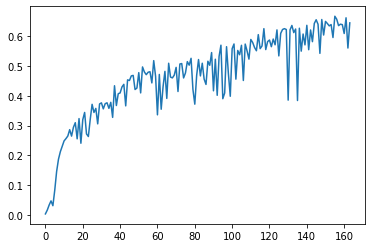

In [7]:
plt.plot(np.asarray(score_list))

(23000.0, 26000.0)

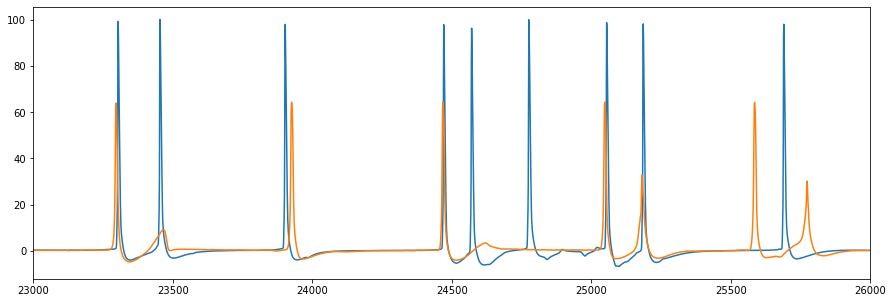

In [8]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy()[part_time_idx])
plt.plot(test_S_out[1].cpu().detach().numpy())
plt.xlim(23000,26000)
#plt.ylim(-1,10)

In [ ]:
np.save()